# **Insurance Dataset**
___

In [1]:
# Se importan las librerías necesarias
library(tidyverse)
#library(ggridges)

# Directorio de trabajo y nombre de archivo
data_folder <- "dataset"
file_name <- "Insurance.csv"

# Se importa el dataset
df_seguros <- read.csv(file.path(data_folder, file_name), dec=",")

# Cambia tamaño del plot
options(repr.plot.width=12, repr.plot.height=10)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v ggplot2 3.1.1       v purrr   0.3.2  
v tibble  2.1.1       v dplyr   0.8.0.1
v tidyr   0.8.3       v stringr 1.4.0  
v readr   1.3.1       v forcats 0.4.0  
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()


In [2]:
# Agrego datos sobre obesidad
df_seguros <- mutate(df_seguros,
                     obesidad = bmi >= 30,
                     rango_etario = case_when((18 <= age & age < 30) ~ '18 a 29', 
                               (30 <= age & age < 40) ~ '30 a 39', 
                               (40 <= age & age < 50) ~ '40 a 49', 
                               (50 <= age & age < 60) ~ '50 a 59', 
                               (60 <= age) ~ '60 <='),
                     salud = case_when((obesidad == TRUE & smoker == 'yes') ~ 'FO', 
                                              (obesidad == TRUE & smoker == 'no') ~ 'O', 
                                              (obesidad == FALSE & smoker == 'yes') ~ 'F', 
                                              (obesidad == FALSE & smoker == 'no') ~ 'S'))

# Summarise de cantidad de habitantes por zona
df_seguros_2 <- group_by(df_seguros, region)
metricas_df2 <- summarise(df_seguros_2, habitantes=n())

# Agrupo para hacer tabla de metricas por region, obesidad y smoker
df_seguros_3 <- group_by(df_seguros, salud, region)
metricas_df3 <- summarise(df_seguros_3,
          mediana_ch=median(charges),
          media_ch=mean(charges),
          cantidad=n(),
          edad_med=median(age))

metricas_merge <- merge(metricas_df2, metricas_df3, by='region')
metricas_merge <- mutate(metricas_merge,
                         poblacion_pje=round(cantidad/habitantes*100, 2),
                         ganancia_grupo=(10000*0.70*0.25)*mediana_ch,
                         ganancia_real=(10000*0.70*0.25*poblacion_pje/100)*mediana_ch)

# Modificar tabla de proporcion 
### TABLA ####

# Calculo ganancias promedio por region
metricas_merge2 <- group_by(metricas_merge, region)
metricas_merge2 <- summarise(metricas_merge2,
                             gananciaG_prom=mean(ganancia_grupo),
                             gananciaG_med=median(ganancia_grupo),
                             gananciaR_total=sum(ganancia_real))

### **Resumen**

Una empresa proveedora de seguros médicos está planeando una campaña publicitaria en la vía pública y desea colocar carteles. Para ello divide el territorio de estudio en 4 zonas con el objetivo de elegir la zona donde pueda maximizar sus ganancias sobre futuros clientes que contraten el seguro. Estudiaremos a continuación el dataset provisto con el fin de contribuir en la toma de decisiones de la empresa.

### **Conociendo qué clientes pagan más**
Considerando que dos factores de riesgo son la obesidad (definida como un índice de masa corporal (BMI) superior a 30) y el consumo de nicotina, se compararon los gastos de seguro médico de personas fumadoras y no fumadoras, separadas por su condición de obesidad.
En el siguiente gráfico se observa que los fumadores tienen más gastos de seguro médico que los no fumadores y, además, si los fumadores son obesos, pagan aún más.

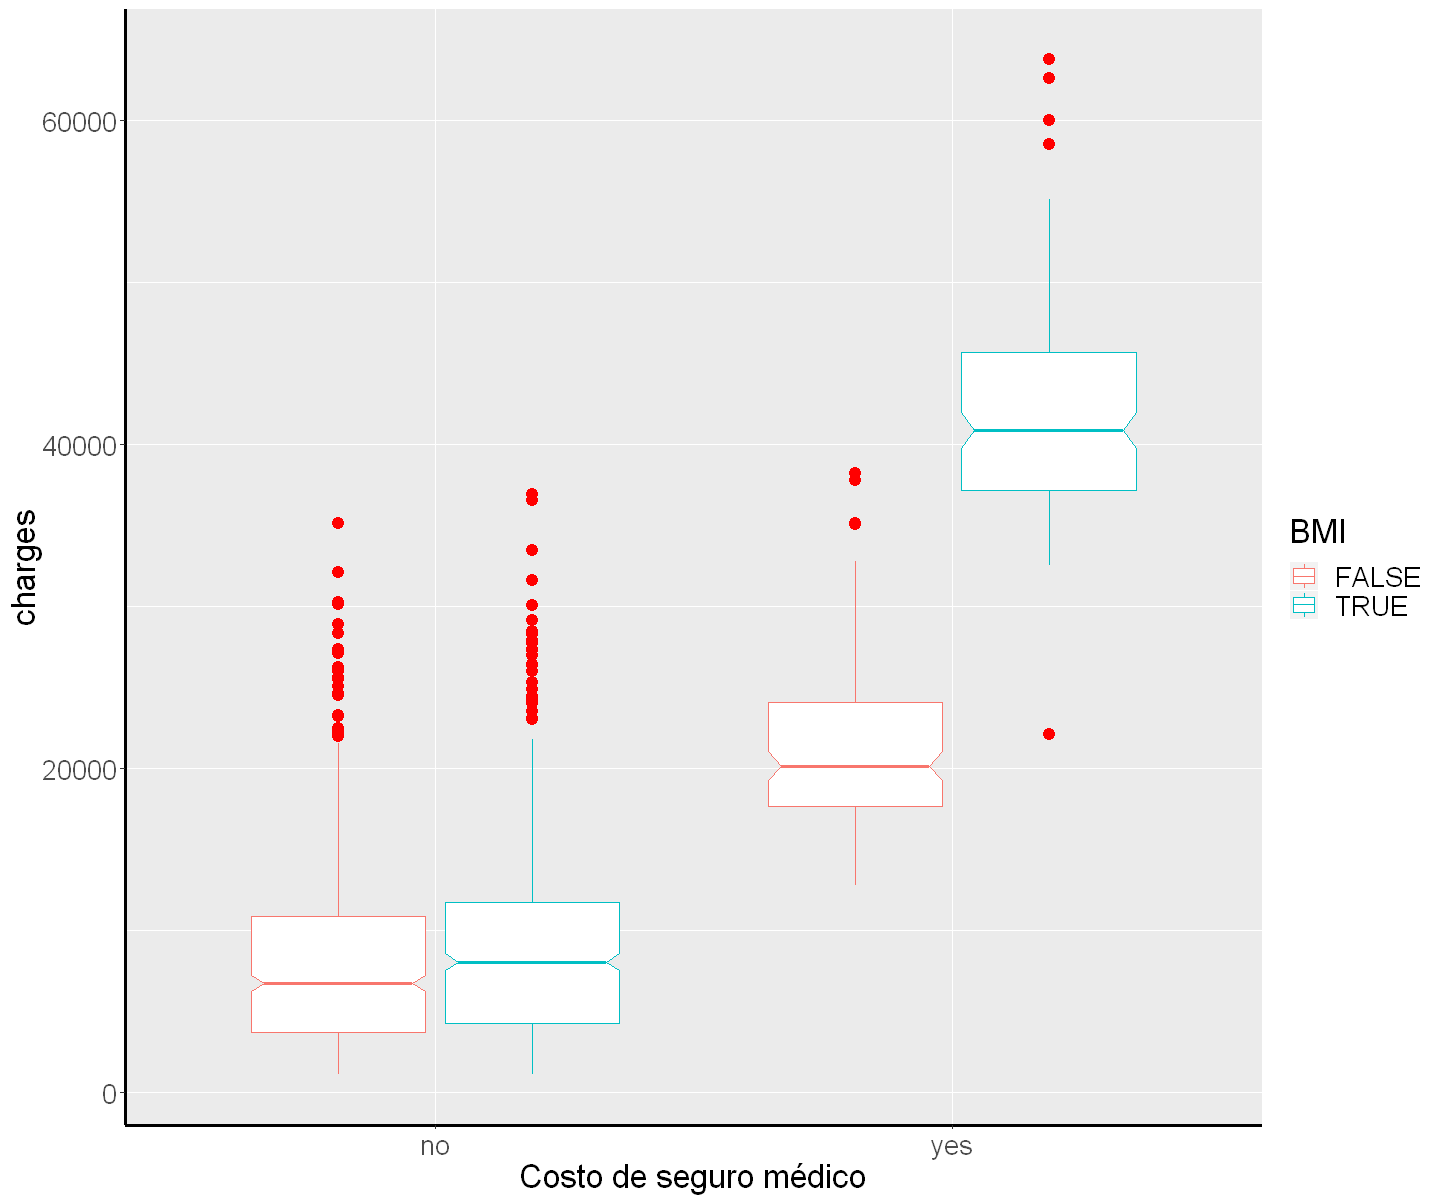

In [3]:
# Boxplot: Personas Sanas / Tabaquismo y Obesidad / Tabaquismo
ggplot(data=df_seguros, aes(x=factor(smoker), y=charges, color=obesidad)) +
  geom_boxplot(outlier.colour = "red", outlier.fill="red", outlier.size=3,
               notch=TRUE, notchwidth = 0.85) +
  labs(
    x = 'Costo de seguro médico',
    #title = 'Fumadores y no fumadores vs costo seguro médico',
    color = 'BMI'
  ) +
  #scale_color_discrete(labels=c('< 30','>= 30')) +
  #scale_y_discrete('Fumador',labels=c('NO','SI')) +
  theme(axis.line = element_line(colour = "black", size = 1), text = element_text(size = 20))

#### ***Figura 1.*** Costo de seguro médico para personas sanas, con obesidad o tabaquismo y con tabaquismo y obesidad. [6]<a id="6"></a>

También se analizó si el tener más hijos, tanto para hombres y como mujeres, modifica el gasto en seguro médico. Inicialmente, se presuponía que en los hombres no habría diferencia en los gastos médicos, sin importar la cantidad de hijos, y que en las mujeres sí, debido a que la gestación genera cambios en el cuerpo y puede incuso generar problemas de salud. A continuación, se puede ver en el gráfico que la cantidad de hijos no es un factor relevante en los gastos de seguro médico, lo que contradice la suposición.

In [4]:
# separo mujeres de hombres
genero <- group_by(df_seguros, sex, children) %>%
  mutate(rango_hijes = case_when(
    (children==0) ~ 'Sin hijes',
    (children > 0 & children <= 2 ) ~ 'Hasta 2 hijes',
    (children > 2) ~ 'Más de 2 hijes'
  ))

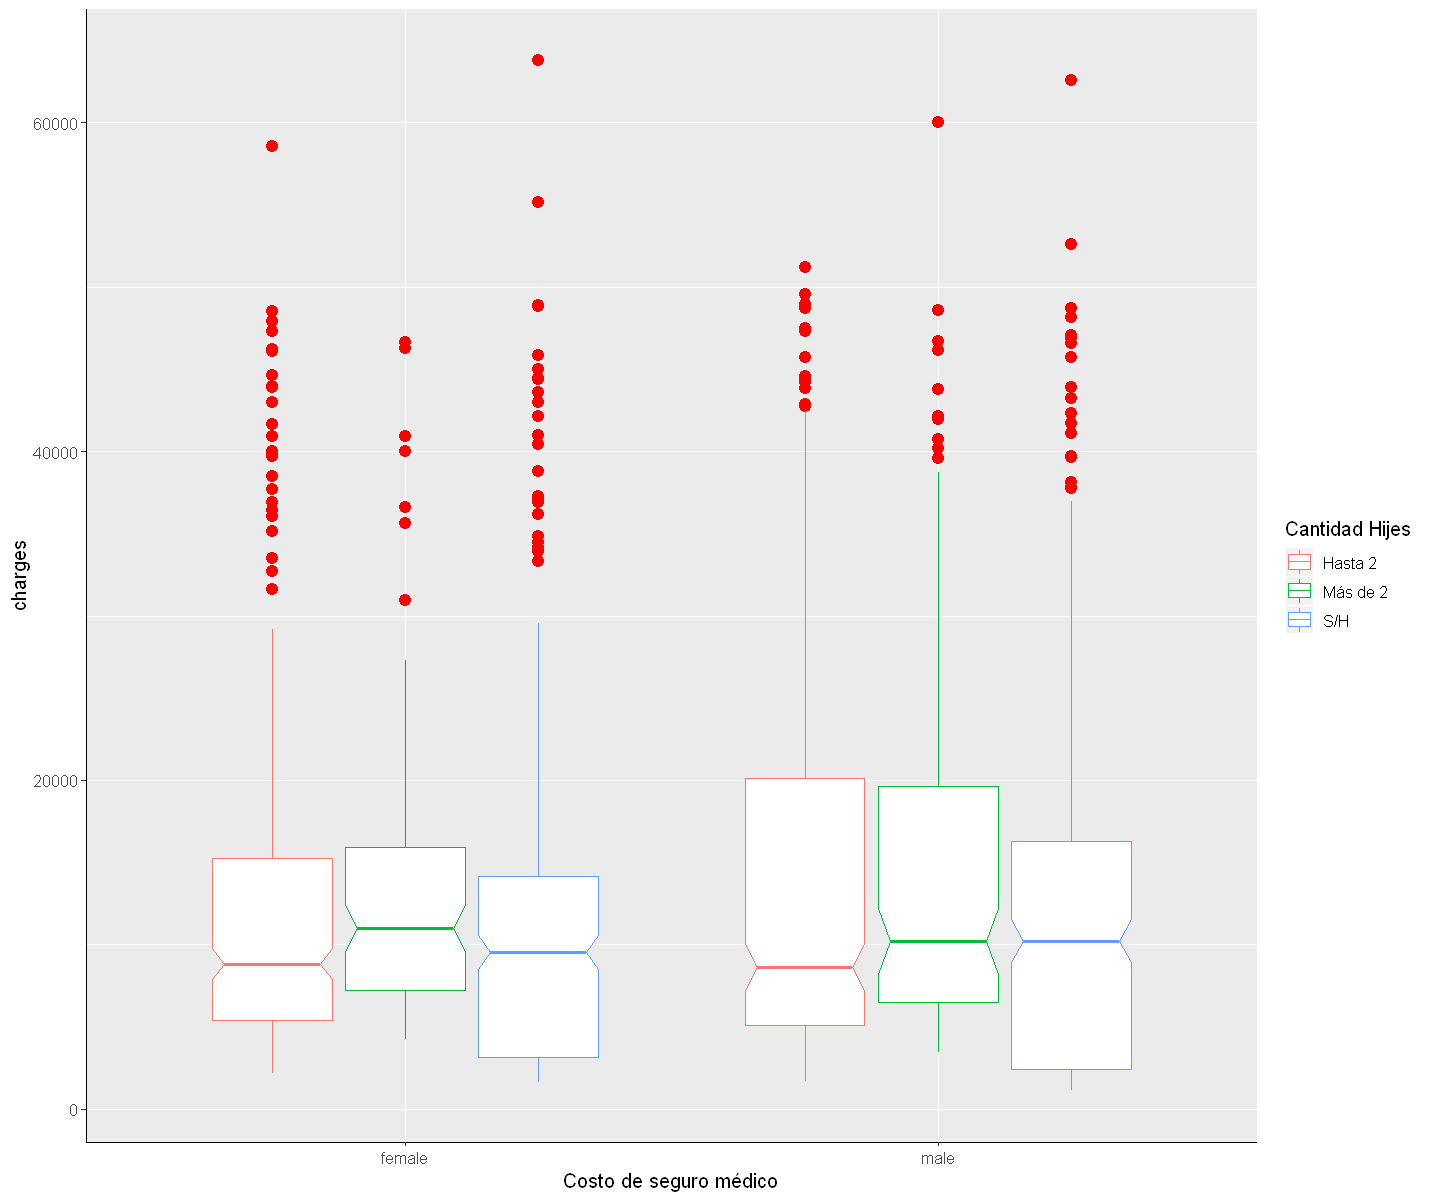

In [5]:
# a cada grupo lo separo por hijos
ggplot(data=genero) +
  geom_boxplot(aes(x=sex, y=charges, color=factor(rango_hijes)),
               outlier.colour = "red", 
               outlier.fill="red", outlier.size=3,
               notch=TRUE, notchwidth = 0.8) + 
  labs(
    x = 'Costo de seguro médico',
    #title = 'Pago de seguro médico por sexo vs cantidad de hijes',
    color = 'Cantidad Hijes'
  ) +
  scale_color_discrete(labels=c('Hasta 2','Más de 2', 'S/H')) +
  #scale_y_discrete('Sexo',labels=c('Femenino','Masculino')) +
  theme(axis.line = element_line(colour = "black", size = 0.5), text = element_text(size = 12))

#### ***Figura 2.*** Costo de seguro médico para hombres y mujeres, según la cantidad de hijos.

### **Buscando la zona adecuada**

En la Fig. 1 [[6]](#6) se mostró que los fumadores y, especialmente los fumadores obesos, son aquellos que pagan mayores sumas por su seguro médico. Sin embargo, mayores ingresos de la empresa no significa mayores ganancias, ya que quedaría por analizar los gastos realizados por los clientes, lo que significa un costo para la empresa. Entonces, es posible que este grupo, que genera mayores ingresos, también sea el grupo que más utilice el servicio, generando mayores gastos en la empresa. Para hacer un análisis más realista, sería necesario tener en cuenta más variables, como la expectativa de vida de los diferentes grupos y los gastos que acarrean. Al no contar con estas variables en el dataset, el análisis se enfocará en maximizar los ingresos de la empresa y no las ganancias.
Se decidió seleccionar la zona que presentaba la mayor proporción de fumadores, y en caso de tener zonas con proporciones similares, enfocarse en la que además tuviera mayores índices de obesidad, ya que este grupo es el que paga mayores sumas por su seguro médico.

In [6]:
#proporcion  <- group_by(metricas_merge, region, salud) %>% summarise(

#metricas_merge_new <- tibble::rownames_to_column(metricas_merge, "row_names")

#metricas_merge_new<-as.data.frame(t(metricas_merge))

#metricas_merge_new <- mutate(metricas_merge, region, SANOS=poblacion_pje[salud])

#ZONA         %SANOS  %OBESOS  %FUMADORES  %FUM OBESOS  
#Northeast    
#Northwest   
#Southeast   
#Southwest

In [7]:
#metricas_merge_new

#### ***Tabla 1.*** Distribución de población por regiones, según sus parámetros de salud.

A partir de estos resultados, se decidió concentrar los esfuerzos en la zona Southeast, ya que tiene una mayor proporción de personas con factores de riesgo que pagarán más seguro médico.

### **Calculando los potenciales beneficios**

Si se colocan 500 carteles en la zona elegida, se estima que se alcanzará al 70% de la población, y de las personas que lo vieron, el 25% contratará el segudo, por lo que en total el 17,5% de la población contratará el seguro. Para un área de 10.000 habitantes, son 1750 nuevos clientes.

Para estimar los beneficios mínimos y máximos, se consideró que el ingreso mínimo ocurre cuando todos los nuevos clientes son no fumadores sin obesidad, y el ingreso máximo ocurre si todos los nuevos clientes son fumadores obesos. El ingreso individual que se consideró es el de la mediana de cada grupo.
Para que estas estimaciones tengan valor se considera que la muestra recibida es representativa de la población.

In [8]:
metricas_merge

region,habitantes,salud,mediana_ch,media_ch,cantidad,edad_med,poblacion_pje,ganancia_grupo,ganancia_real
northeast,324,F,20223.090,20819.646,38,38.0,11.73,35390408,4151295
northeast,324,FO,40904.200,41275.186,29,40.0,8.95,71582350,6406620
northeast,324,O,9870.990,10280.101,114,46.0,35.19,17274233,6078802
northeast,324,S,7077.190,8276.994,143,36.0,44.14,12385083,5466775
northwest,325,F,21472.480,22152.991,35,42.0,10.77,37576840,4047026
northwest,325,FO,42760.500,42425.281,23,44.0,7.08,74830875,5298026
northwest,325,O,7749.160,9136.771,125,41.0,38.46,13561030,5215572
northwest,325,S,6675.560,8045.630,142,37.0,43.69,11682230,5103966
southeast,364,F,19539.240,21819.506,33,40.0,9.07,34193670,3101366
southeast,364,FO,41974.380,42256.053,58,42.5,15.93,73455165,11701408


#### ***Tabla 1.*** Donde, personas S: sanas, O: obesas, F: fumadores y FO: fumadoras y obesas.

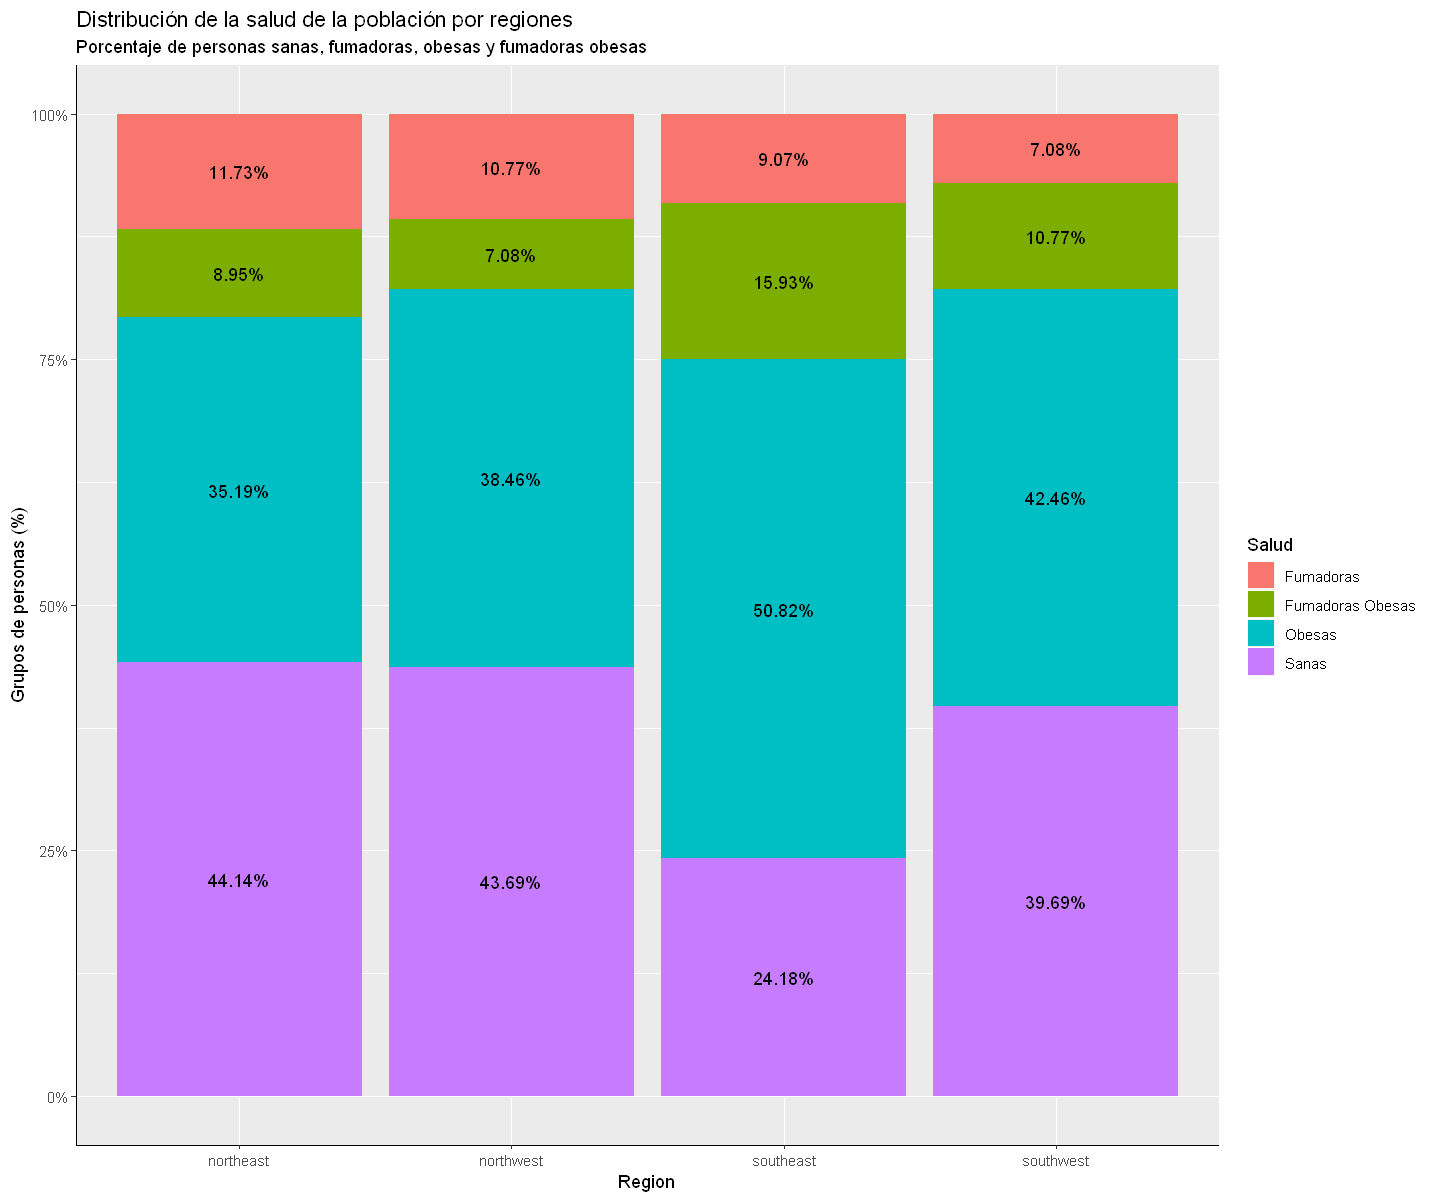

In [9]:
# Grafico de porcentaje de poblacion por grupo
ggplot(metricas_merge, aes(fill=salud, y=poblacion_pje, x=region)) + 
  geom_bar(position="fill", stat="identity") +
  labs(
    title = "Distribución de la salud de la población por regiones",
    subtitle = "Porcentaje de personas sanas, fumadoras, obesas y fumadoras obesas",
    fill = "Salud"
  ) +
  xlab("Region") +
  ylab("Grupos de personas (%)") +
  scale_fill_discrete(labels=c('Fumadoras', 'Fumadoras Obesas', 'Obesas', 'Sanas')) +
  scale_y_continuous(labels = scales::percent_format(accuracy = 1)) +
  geom_text(aes(label = paste0(poblacion_pje,"%")),
            colour = "black",
            position = position_fill(vjust = 0.5)) +
  theme(axis.line = element_line(colour = "black", size = 0.5))

Con estos resultados, se decidió concentrar los esfuerzos en la zona Southeast, ya que tiene una mayor proporción de personas con factores de riesgo que pagarán más seguro médico.

## Calculando los potenciales beneficios

Si se colocan 500 carteles en la zona elegida, se estima que se alcanzará al 70% de la población, y de las personas que lo vieron, el 25% contratará el segudo, por lo que en total el 17,5% de la población contratará el seguro. Para un área de 10.000 habitantes, son 1750 potenciales nuevos clientes.

Para cada grupo con distintos factores de riesgo se calculó la mediana por edad y se hizo un gráfico de puntos. De este modo se hizo una regresión lineal para poder estimar el ingreso por edad.

In [10]:
df_seguros <- mutate(df_seguros,
                     obesidad = bmi >= 30,
                     rango_etario = case_when((18 <= age & age < 30) ~ '18 a 29', 
                               (30 <= age & age < 40) ~ '30 a 39', 
                               (40 <= age & age < 50) ~ '40 a 49', 
                               (50 <= age & age < 60) ~ '50 a 59', 
                               (60 <= age) ~ '60 <='),
                     salud = case_when((obesidad == TRUE & smoker == 'yes') ~ 'FO', 
                                              (obesidad == TRUE & smoker == 'no') ~ 'O', 
                                              (obesidad == FALSE & smoker == 'yes') ~ 'F', 
                                              (obesidad == FALSE & smoker == 'no') ~ 'SANO'))
df_seguros_3 <- group_by(df_seguros, salud, age)
metricas_df3 <- summarise(df_seguros_3,
          mediana_ch=median(charges),
          media_ch=mean(charges),
          cantidad=n()
          )

In [ ]:
library(ggpubr)

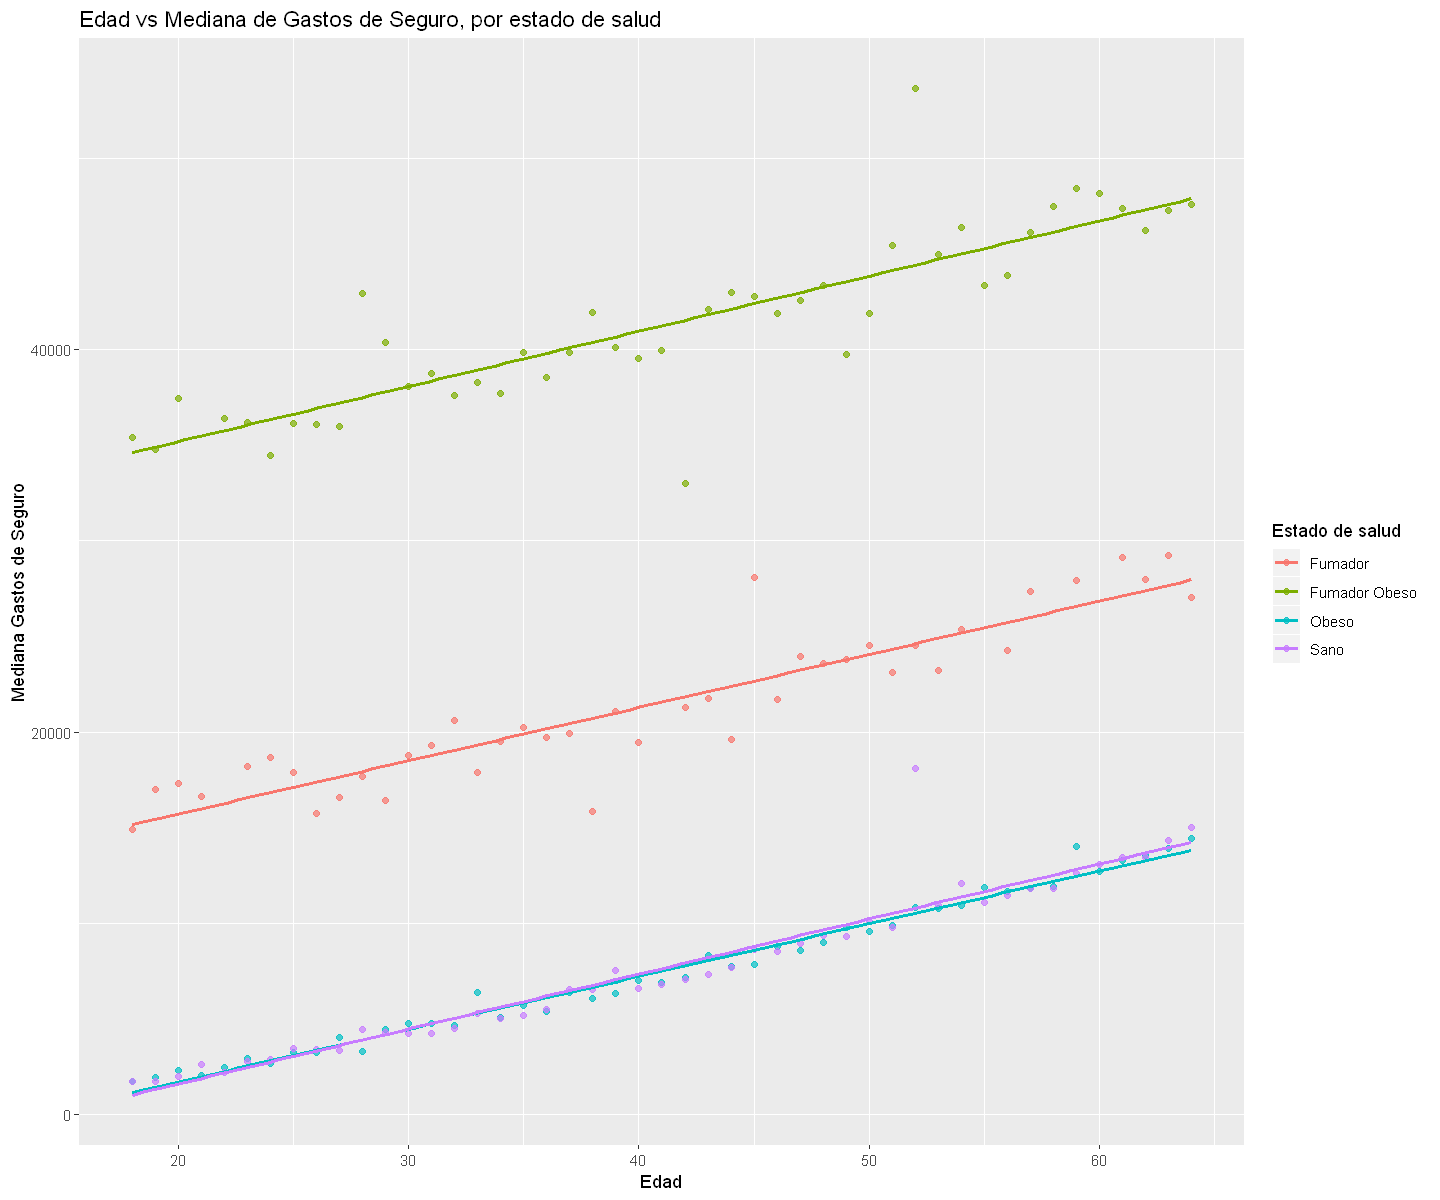

In [11]:
ggplot(metricas_df3, aes(x=age, y=mediana_ch, color = salud)) +
  geom_point(alpha=0.7) + geom_smooth(method='lm', se=FALSE, formula= y ~ x) +
  #stat_regline_equation(aes(label = ..eq.label..)) +
  labs(
    x = 'Edad',
    y = 'Mediana Gastos de Seguro',
    title = 'Edad vs Mediana de Gastos de Seguro, por estado de salud',
    # tag = 'Se incluyen las ecuaciones de las líneas de tendencia',
    color = 'Estado de salud'
  ) +
  scale_color_discrete(labels = c('Fumador','Fumador Obeso','Obeso','Sano'))

#### made it by: <a id="5"></a> Pablo Peitsch <a href="https://github.com/PPeitsch">@PPeitsch</a>